<h2><center>
Entrenamiento modelo de NER (named entity recognition) con libreria SPACY </center></h2>

<h3><center>Curso de Tecnologias Disruptivas 2023-II</center></h3>


<h6><center>Carlos Perdomo Lozada</center></h6>
<h6><center>Joshua Sanches Alvarez</center></h6>
<h6><center>Arley Reina Saldaña</center></h6>

Guia [Entrenamiento NER Spacy](https://github.com/explosion/projects/tree/v3/tutorials/ner_drugs)

Dataset
* [Drugs_train.jsonl](https://github.com/explosion/projects/blob/v3/tutorials/ner_drugs/assets/drugs_eval.jsonl)

* [Drugs_eval.jsonl](https://github.com/explosion/projects/blob/v3/tutorials/ner_drugs/assets/drugs_eval.jsonl)

Dataset generado desde el hilo de la red social reddit sobre drogas, donde por cada comentario se busca y etiquetan las drogas mencionadas por los participantes del hilo


Distribucion de los datos :
- 1477  muestras para entrenamiento
- 500 muestras para test

In [1]:
# Importamos librerias
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cambiamos el path de ejecucion
%cd /content/drive/MyDrive/Tecnologias disruptivas - equipo/TRABAJO FINAL

/content/drive/.shortcut-targets-by-id/13hv4z1sBEkmKdKrB0i4POVsjV-QW2Ph_/Tecnologias disruptivas - equipo/TRABAJO FINAL


## Exploracion de los datos

In [3]:
import typer
import srsly
from pathlib import Path
from spacy.util import get_words_and_spaces
from spacy.tokens import Doc, DocBin
from spacy import displacy
import spacy
import logging
import random
logging.basicConfig(level=logging.DEBUG,force=True)

In [4]:
input_path_drugs = './datasets/drugs_training.jsonl'
input_path_drugs_val = './datasets/drugs_eval.jsonl'
output_path = './train_drugs.spacy'
output_path_val = './val_drugs.spacy'

In [5]:
def load_data(filepath):
  '''
  param : filepath : ruta del achivo jsonl con el dataset crudo
  return : data : texto que aparece en cada una de las filas
        : label : etiqueta de la entidad en este caso "DRUG"
        : n_total_ents : numero total de muestras
        : n_no_ents : Numero total de muestras sin la aparicion de la entidad
  '''
  examples = list(srsly.read_jsonl(filepath))
  rows = []
  n_total_ents = 0
  n_no_ents = 0
  labels = set()
  for eg in examples:
      row = {"text": eg["text"], "ents": eg.get("spans", [])}
      n_total_ents += len(row["ents"])
      if not row["ents"]:
          n_no_ents += 1
      labels.update([span["label"] for span in row["ents"]])
      rows.append(row)
  return rows, labels, n_total_ents, n_no_ents

data, labels, n_total_ents, n_no_ents = load_data(input_path_drugs)


In [6]:
logging.info(f'Cantidad total de muestras {str(len(data))}')
logging.info(f'Cantidad total de entidades {str(n_total_ents)}')
logging.info(f'Cantidad total de muestras sin entidad {str(n_no_ents)}')

INFO:root:Cantidad total de muestras 1477
INFO:root:Cantidad total de entidades 1105
INFO:root:Cantidad total de muestras sin entidad 1023


In [7]:
# Veamos algunas de las muestras con sus respectivas etiquetas

displacy_settings = {
        "style": "ent",
        "jupyter":True,
        "manual": True,
        "options": {"colors": {
            label: "linear-gradient(80deg, #09203f, #537895)" for label in labels}},
     }

elemnts_rand = random.choices(data, k=6)

for sample_rand in elemnts_rand:
  print('_'*80)
  displacy.render(sample_rand,**displacy_settings)

________________________________________________________________________________


________________________________________________________________________________


________________________________________________________________________________


________________________________________________________________________________


________________________________________________________________________________


________________________________________________________________________________


## Preprocesamiento de los datos

Para el entrenamiento es necesario generar los archivos de entrenamiento y validacion que permitan tomar el pipeline de entrenamiento con formato *.spacy* lo que permite estandarizar las muestras para el entranmiento.

Las siguientes 2 celdas se encargar de:

 * Crear un "modelo" en blanco con idioma ingles que contiene encoders prentrenados
 * Asignar atributos de forma del dataset y su estilo de etiquetado en este caso "IOB" para busqueda de entidades"
 * Carga de las muestras y seleccion de aquellas que fueron "aceptadas" por el tiquetador
 * Formatear y añadir las nuevas muestras al modelo en blanco con la respectiva etiqueta
 * Guardar el archivo *.spacy*

In [ ]:
nlp = spacy.blank("en")
doc_bin = DocBin(attrs=["ENT_IOB", "ENT_TYPE"])

for eg in srsly.read_jsonl(input_path_drugs):
  if eg["answer"] != "accept":
    continue
  tokens = [token["text"] for token in eg["tokens"]]
  words, spaces = get_words_and_spaces(tokens, eg["text"])
  doc = Doc(nlp.vocab, words=words, spaces=spaces)
  doc.ents = [
      doc.char_span(s["start"], s["end"], label=s["label"])
      for s in eg.get("spans", [])]
  doc_bin.add(doc)

doc_bin.to_disk(output_path)

In [ ]:
nlp = spacy.blank("en")
doc_bin2 = DocBin(attrs=["ENT_IOB", "ENT_TYPE"])

for eg in srsly.read_jsonl(input_path_drugs_val):
  if eg["answer"] != "accept":
      continue
  tokens = [token["text"] for token in eg["tokens"]]
  words, spaces = get_words_and_spaces(tokens, eg["text"])
  doc = Doc(nlp.vocab, words=words, spaces=spaces)
  doc.ents = [
      doc.char_span(s["start"], s["end"], label=s["label"])
       for s in eg.get("spans", [])]
  doc_bin2.add(doc)

doc_bin2.to_disk(output_path_val)

In [ ]:
logging.info(f"Datos procesados para entrenamiento {str(len(doc_bin))} Ruta: {output_path}")
logging.info(f"Datos procesados para validacion {str(len(doc_bin2))} Ruta: {output_path_val}")

INFO:root:Datos procesados para entrenamiento 1477 Ruta: ./train_drugs.spacy
INFO:root:Datos procesados para validacion 500 Ruta: ./val_drugs.spacy


## Entrenamiento

La libreria spacy nos permite generar un pipeline de entrenamiento el cual recibe por parametros:

* Archivo de configuracion: es un archivo .cfg parecido a un archivo de texto plano el cual contiene los hiperparametros obligatorios que seben ser configurados para el entrenamiento

* Ruta de salida : Ruta en donde se guardara el modelo resultante

* Ruta de datos de entrenamiento: Ruta de el archivo de entrenamiento .spacy que creamos en el paso anterior

* Ruta de datos de validacion: Ruta de el archivo de validacion .spacy que creamos en el paso anterior

* Uso de GPU (bandera opcional): Permite setear el entrenamiento por GPU, el cual usaremos dado que usamos los recursos de GOOGLE COLAB

 Para generar el archivo de hiperparametros que corresponda al pipeline de entrenamiento la libreria nos proporciona la interfaz para generar el archivo desde la [pagina oficial](https://spacy.io/usage/training) solo bastara con seleccionar los parametros requeridos como se muestra en la imagen:

 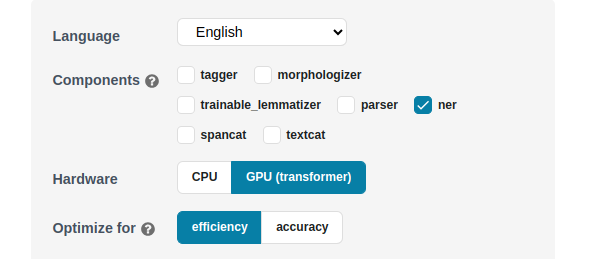

 El archivo resultante se descarga y su ruta sera pasada como parametros en los siguientes codigos con el nombre "config.cfg"

El archivo anterior solo cuenta con los datos base, con el siguente codigo llamamos la libreria spacy y se pasa por parametro el archivo de configuracion para que termine de ser llenado con los parametros faltantes por default y generando el archivo final de hiperparametros "base_config.cfg" que llegara al pipeline de entrenamiento.

In [ ]:
# Notese que se ejecuta por consola de comandos con "!"
!python -m spacy init fill-config base_config.cfg config.cfg

2023-10-04 13:44:29.729291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
# Iniciamos el entrenamiento
!python -m spacy train config.cfg --output ./output_drugs_test --code FUNCTIONS.py --paths.train ./train_drugs.spacy --paths.dev ./val_drugs.spacy --gpu-id 0

2023-10-04 13:45:47.398822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: output_drugs_test
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
Logging to my_file.tab\n✔ Saved pipeline to output directory
output_drugs_test/model-last


In [ ]:
# Cargamos el archivo de logs de entrenamiento my_file.tab
def read_log_file(path_file):
  rows = []
  myFile= open(path_file, "r" )
  for aRow in myFile:
    rows.append(aRow.split('\\n'))
  myFile.close()

  columns = [col.split('\\t') for col in rows[0]]

  df_logs = pd.DataFrame(columns)
  df_logs.columns = df_logs .iloc[0]
  df_logs = df_logs[1:]
  df_logs = df_logs.reset_index(drop=True)
  df_logs = df_logs[['step', 'score', 'loss_tok2vec', 'loss_ner']]
  df_logs.drop(index=df_logs.index[-1],axis=0,inplace=True)
  df_logs['step'] = df_logs['step'].astype(int)
  df_logs['score'] = df_logs['score'].astype(float)
  df_logs['loss_tok2vec'] = df_logs['loss_tok2vec'].astype(float)
  df_logs['loss_ner'] = df_logs['loss_ner'].astype(float)
  return df_logs

logs_df = read_log_file('./my_file.tab')

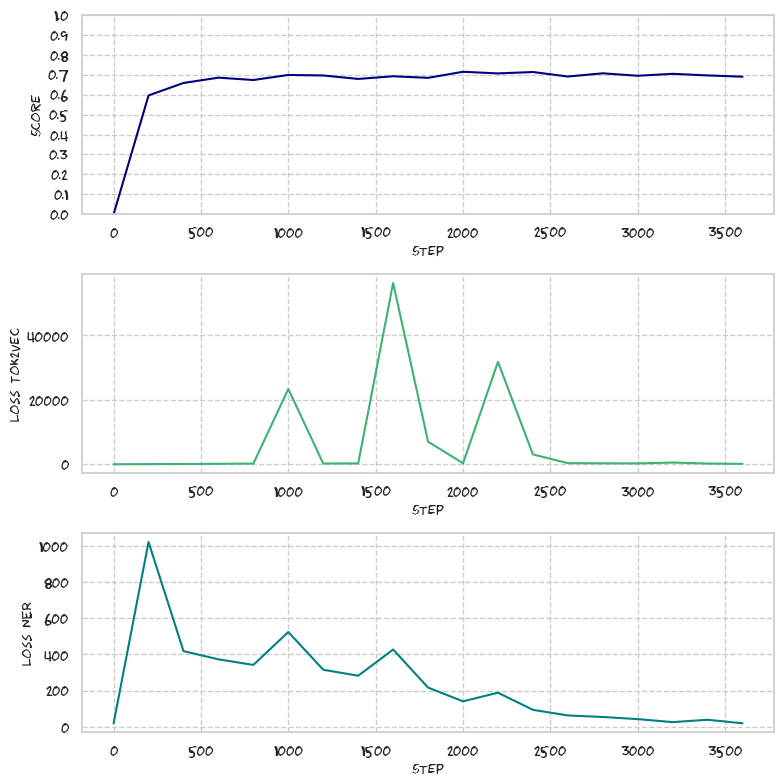

In [ ]:
# Veamos las curvas de aprendizaje del modelo con sus metricas

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


sns.set_style('whitegrid',
 {'grid.linewidth': 0.5,
  'grid.linestyle': '--',
  "ytick.major.size": 0.1,
  "ytick.minor.size": 0.05})

sns.set_context()


plt.rcParams.update({'font.family':'fantasy'})
plt.figure(figsize=(8, 8))


# Gráfica 1
plt.subplot(3, 1, 1)
sns.lineplot(x='step', y='score', data=logs_df[::-1], color='navy')
plt.ylabel('Score',  fontweight='light', fontstyle='italic', fontsize='small')
plt.xlabel('Step',  fontweight='light', fontstyle='italic', fontsize='small')
plt.ylim([0, 1])
plt.locator_params(axis='y', nbins=10)

#relacion entre la precision y el recall

# Gráfica 2
plt.subplot(3, 1, 2)
sns.lineplot(x='step', y='loss_tok2vec', data=logs_df, color='mediumseagreen')
plt.ylabel('Loss Tok2Vec', fontweight='light', fontstyle='italic', fontsize='small')
plt.xlabel('Step', fontweight='light', fontstyle='italic', fontsize='small')
#plt.title('Loss Tok2Vec', fontweight='bold')

# Gráfica 3
plt.subplot(3, 1, 3)
sns.lineplot(x='step', y='loss_ner', data=logs_df, color='teal')
plt.ylabel('Loss NER', fontweight='light', fontstyle='italic', fontsize='small')
plt.xlabel('Step',  fontweight='light', fontstyle='italic', fontsize='small')

plt.tight_layout()
plt.show()


In [ ]:
# veamos el modelo original

nlp = spacy.load('en_core_web_sm')
doc = nlp("Hi I really like tylenol, cocaine and weed.")
options = {"compact": True, "bg":
           '#eca053',
           "color": "black", "font": "Source Sans Pro"}
displacy.render(doc, style="dep", jupyter=True, options=options)

In [ ]:
# veamos el modelo entrenado
colors = {"DRUG": "linear-gradient(90deg, #eca053, #ebc8a4)"}
options = {"ents": ["DRUG"], "colors": colors}
displacy.render(doc, style="ent", jupyter=True, options=options)


In [ ]:
trained_nlp = spacy.load("output_drugs/model-best")
text = 'Hi i really like tylenol, cocaine and weed'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

tylenol DRUG
cocaine DRUG
weed DRUG


In [ ]:
text = 'Hi I really like tylenol, cocaine and weed.'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

tylenol DRUG
cocaine DRUG
weed DRUG


In [ ]:
text = 'What is de benzos and how much cost'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

benzos DRUG


In [ ]:
text = 'What is de hydrocodone and how much cost'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

hydrocodone DRUG


In [ ]:
text = 'In this proyect you will know drugs like Suboxone'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

drugs DRUG
Suboxone DRUG


In [ ]:
text = 'The people in too many states consume fentanyl'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

fentanyl DRUG


In [ ]:
text = 'We really like heroine and is much better with cannabis'
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

heroine DRUG


In [ ]:
text = 'maybe the model recognize marijuana as cannabis '
doc = trained_nlp(text)

for ent in doc.ents:
    print (ent.text, ent.label_)

marijuana DRUG
